# Project 2
#### Problem Statement

> An analysis of paleo-present climate data
>
> * Analyse CO2 vs Temperature Anomaly from 800kyrs – present.
> * Examine one other (paleo/modern) features (e.g. CH4 or polar ice-coverage)
> * Examine Irish context:
>   * Climate change signals: (see Maynooth study: The emergence of a climate change signal in long-term Irish meteorological observations - ScienceDirect)
> * Fuse and analyse data from various data sources and format fused data set as a pandas dataframe and export to csv and json formats
> * For all of the above variables, analyse the data, the trends and the relationships between them (temporal leads/lags/frequency      analysis).
> * Predict global temperature anomaly over next few decades (synthesise data) and compare to published climate models if atmospheric CO2 trends continue
> * Comment on accelerated warming based on very latest features (e.g. temperature/polar-icecoverage)
>
> Use a Jupyter notebook for your analysis and track your progress using GitHub.
>
> Use an academic referencing style


In [52]:
# Import the following libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import netCDF4
from netCDF4 import Dataset
#from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Install xlrd in anaconda to allow pandas to read .xls files\
use the following command: conda install -c anaconda xlrd\
https://anaconda.org/anaconda/xlrd
Install netCDF4 for sea ice data
https://unidata.github.io/netcdf4-python/\
use the following command: conda install -c conda-forge netCDF4

In [53]:
# Example of how to download xl files and create csv files

# CO2 data from Luthi et al. 2008 Nature Paper
url = 'data/41586_2008_BFnature06949_MOESM31_ESM.xls'

Sheet1 = 'data/csv_files/2008_nature_new_CO2_data.csv'
Sheet2 = 'data/csv_files/2008_nature_Vostok_TD_Dome_C.csv'
Sheet3 = 'data/csv_files/2008_nature_Composite_CO2.csv'
df1=pd.read_excel(url, '1.  new CO2 data')
df2=pd.read_excel(url, '2.  Vostok-TD-Dome C')
df3=pd.read_excel(url, '3.  Composite CO2')

df1.to_csv(Sheet1)
df2.to_csv(Sheet2)
df3.to_csv(Sheet3)

## Introduction
***
Chemist Charles Keeling started measuring CO<sub>2</sub> levels in 1955 and in 1958 he began taking daily measurements at Mauna Loa in Hawaii which still continues today. He noted that CO<sub>2</sub> levels were rising and by 2008 had noted an increase from 315 ppm to 380 ppm[1]As our understanding of climate grows, evidence of the influence of man-made greenhouse gases on climate change is increasing[2]. In this project I will look at some of the data associated with this issue.

CO2 from Mauna Loa below
https://gml.noaa.gov/ccgg/trends/data.html

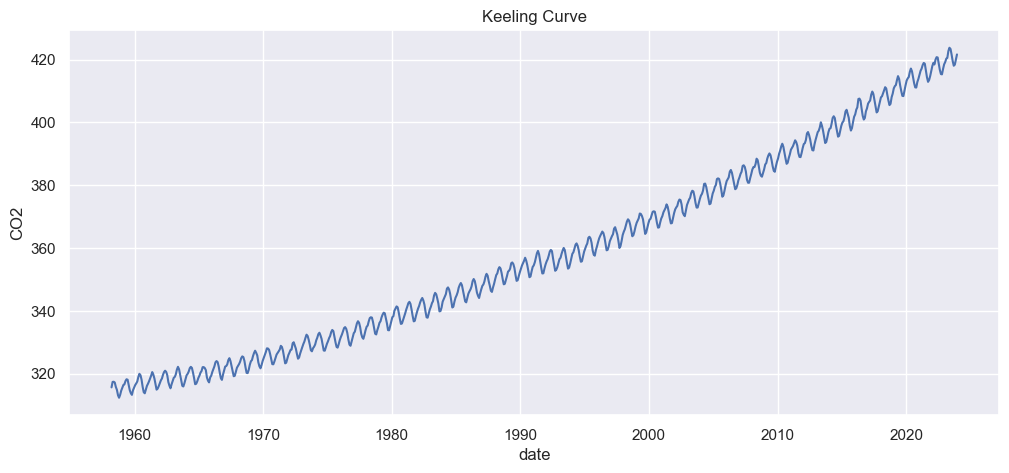

In [103]:
df_mlo=pd.read_csv('data/csv_files/monthly_in_situ_co2_mlo.csv')

sns.lineplot(x = 'date', y = 'CO2', data=df_mlo).set( title='Keeling Curve')
plt.show()

In [55]:
df = pd.DataFrame().assign(nature_year =df3['Composite CO2 record (0-800 kyr BP)'], nature_co2_ppmv = df3['Unnamed: 1'])
df = df.drop(labels=range(0, 6), axis=0)

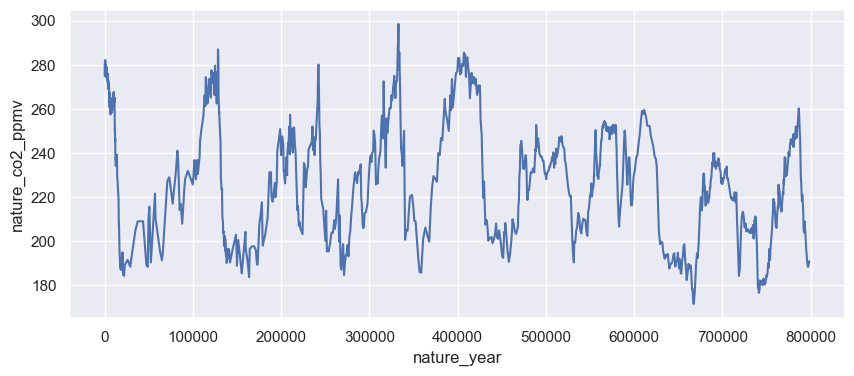

In [56]:
# Replicate plot year vs CO2

plt.style.use('ggplot')
sns.set(rc = {'figure.figsize':(10, 4)})
sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv', data=df)
plt.show()

In [57]:
df4=pd.read_csv('data/csv_files/grl52461_composite_data.csv')
df.insert(2, 'IPCC_year', df4['Gasage (yr BP)'])
df.insert(3, 'IPCC_co2_ppmv', df4['CO2 (ppmv)'])

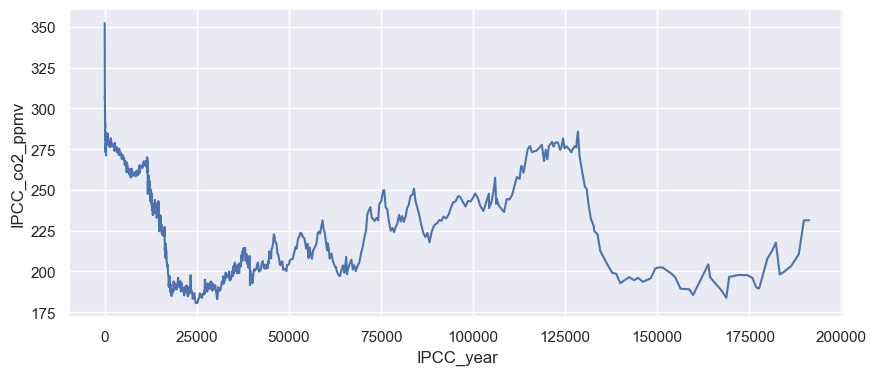

In [58]:
sns.lineplot(x = 'IPCC_year', y = 'IPCC_co2_ppmv', data=df)

plt.show()

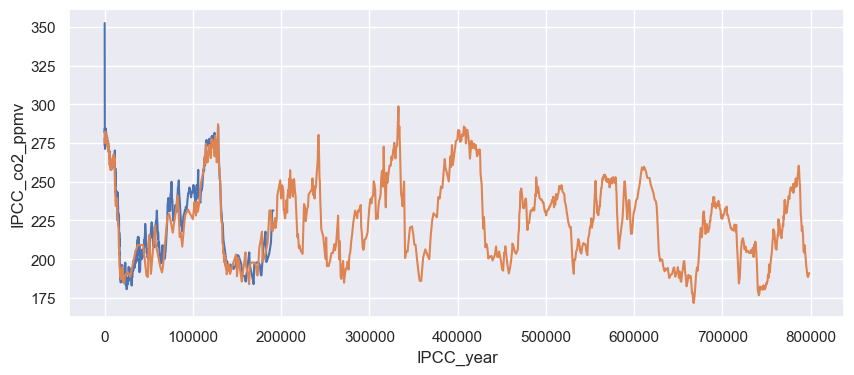

In [59]:
sns.lineplot(x = 'IPCC_year', y = 'IPCC_co2_ppmv', data=df)
sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv', data=df)
plt.show()

In [60]:
df.to_csv('data/csv_files/co2_data.csv')

In [61]:
df5=pd.read_csv('data/csv_files/edc3deuttemp_2007.csv')
df6=pd.read_csv('data/csv_files/epicaDC_deuttemp_EDC3-AICC.csv', encoding = "ISO-8859-1")

In [62]:
df_temp = pd.DataFrame().assign(edc_age =df5['Age'], edc_temp_anomaly = df5['Temperature'])
df_temp.insert(2, 'epica_age', df6['EDC3béta'])
df_temp.insert(3, 'epica_temp', df6['temp'])

df_temp['edc_temp'] = df_temp['edc_temp_anomaly']
temp_column = df_temp['edc_temp']
def add_offset(x):
    x += 218.3
    return x
new_temp_column = temp_column.apply(add_offset)
df_temp['edc_temp'] = new_temp_column

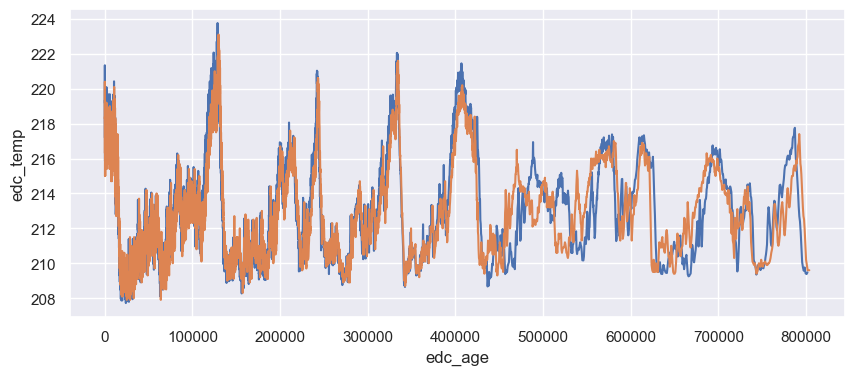

In [63]:
sns.lineplot(x = 'edc_age', y = 'edc_temp', data=df_temp)
sns.lineplot(x = 'epica_age', y = 'epica_temp', data=df_temp)
plt.show()

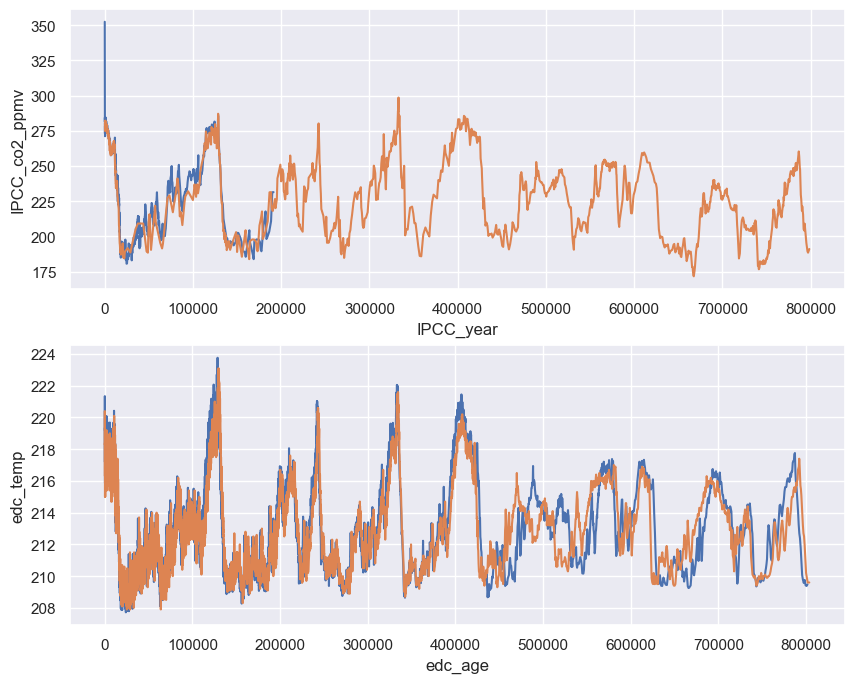

In [64]:
# co2 vs. temp
sns.set(rc = {'figure.figsize':(10, 8)})
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=False)

sns.lineplot(x = 'IPCC_year', y = 'IPCC_co2_ppmv', data=df, ax = ax1)
sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv', data=df, ax = ax1)
sns.lineplot(x = 'edc_age', y = 'edc_temp', data=df_temp, ax = ax2)
sns.lineplot(x = 'epica_age', y = 'epica_temp', data=df_temp, ax = ax2)
plt.show()

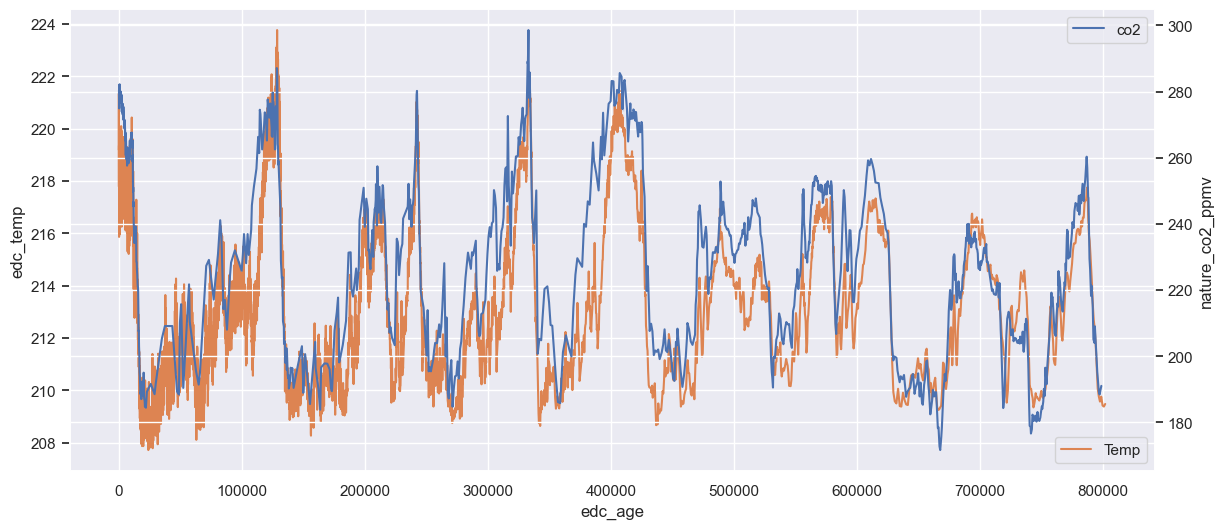

In [65]:
# co2 vs. temp overlay
sns.set(rc = {'figure.figsize':(14, 6)})
fig, (ax) = plt.subplots(nrows=1, sharex=False)

sns.lineplot(x = 'edc_age', y = 'edc_temp', data=df_temp,color='#dd8452', label = 'Temp').legend(loc=4)
ax2 = plt.twinx()
sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv', data=df, label = 'co2')
plt.show()



#### Investigate lead/lag
lets plot co2 vs. temp change

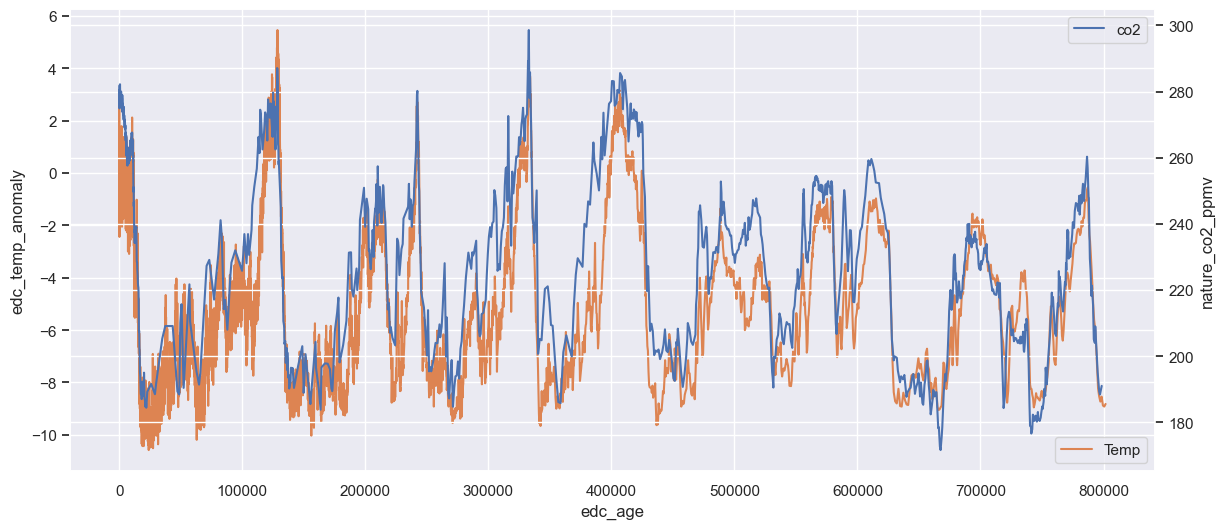

In [66]:
sns.lineplot(x = 'edc_age', y = 'edc_temp_anomaly', data=df_temp,color='#dd8452', label = 'Temp').legend(loc=4)
ax2 = plt.twinx()
sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv', data=df, label = 'co2')
plt.show()

we can see that co2 lags temp slightly\
we will look at 100,000 to 400,000 years ago to get a clearer picture

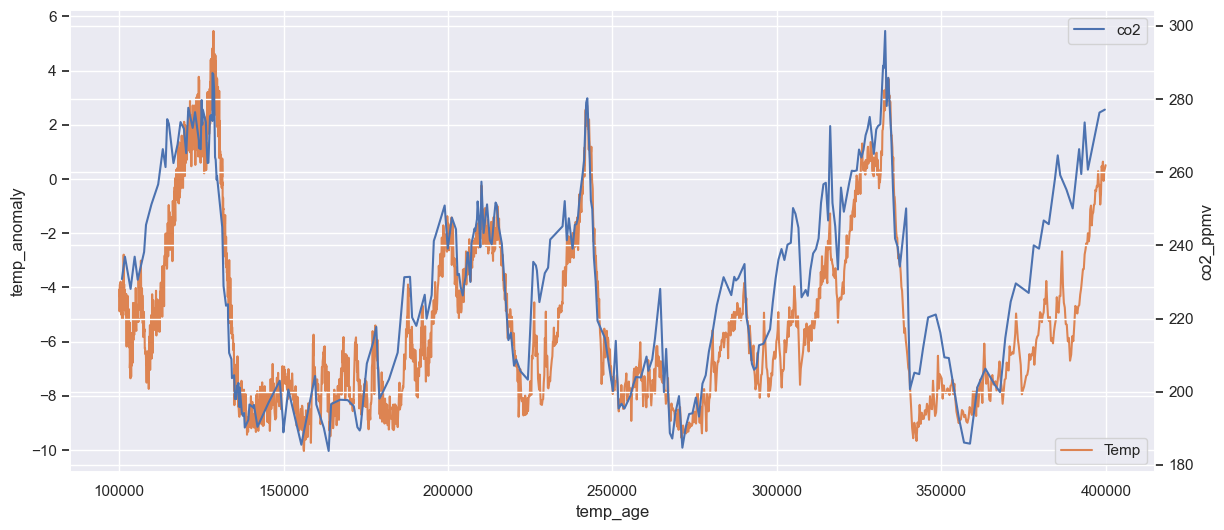

In [67]:
df_10_40k_temp = pd.DataFrame().assign(temp_age =df_temp['edc_age'], temp_anomaly = df_temp['edc_temp_anomaly'])
df_10_40k_temp = df_10_40k_temp.loc[(df_10_40k_temp['temp_age'] >= 100000) & (df_10_40k_temp['temp_age'] <= 400000)]
df_10_40k_co2 = pd.DataFrame().assign(co2_age =df['nature_year'], co2_ppmv = df['nature_co2_ppmv'])
df_10_40k_co2 = df_10_40k_co2.loc[(df_10_40k_co2['co2_age'] >= 100000) & (df_10_40k_co2['co2_age'] <= 400000)]

sns.lineplot(x = 'temp_age', y = 'temp_anomaly', data=df_10_40k_temp, color='#dd8452', label = 'Temp').legend(loc=4)
ax2 = plt.twinx()
sns.lineplot(x = 'co2_age', y = 'co2_ppmv', data=df_10_40k_co2, label = 'co2')
plt.show()


<Axes: xlabel='co2_age', ylabel='co2_ppmv'>

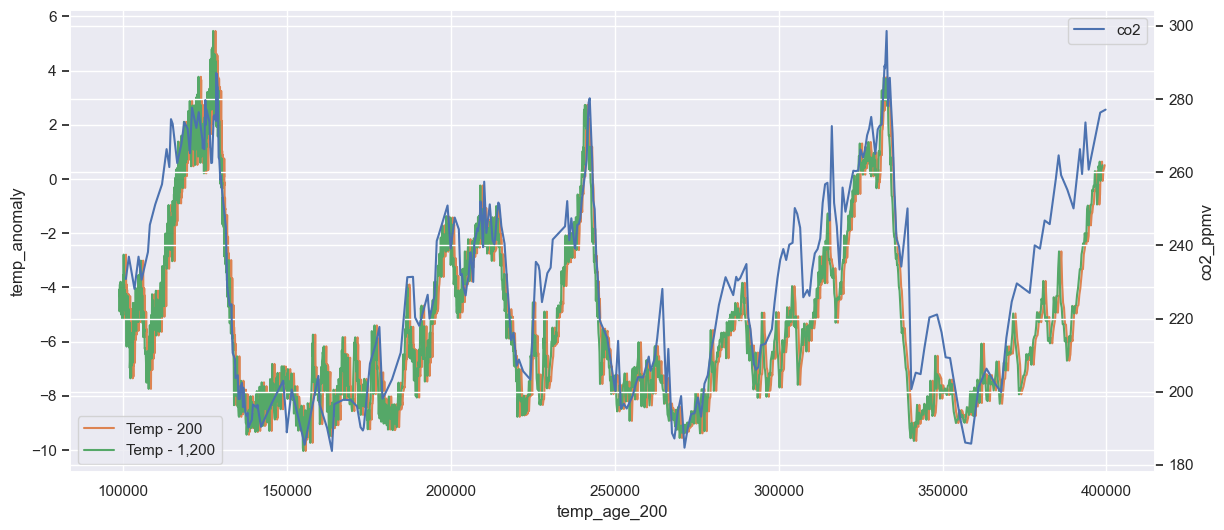

In [68]:
df_10_40k_temp['temp_age_200'] = df_10_40k_temp['temp_age']
temp_column = df_10_40k_temp['temp_age_200']
def add_offset(x):
    x -= 500
    return x
new_temp_column = temp_column.apply(add_offset)
df_10_40k_temp['temp_age_200']= new_temp_column

df_10_40k_temp['temp_age_1200'] = df_10_40k_temp['temp_age']
temp_column = df_10_40k_temp['temp_age_1200']
def add_offset(x):
    x -= 1200
    return x
new_temp_column = temp_column.apply(add_offset)
df_10_40k_temp['temp_age_1200']= new_temp_column

sns.lineplot(x = 'temp_age_200', y = 'temp_anomaly', data=df_10_40k_temp, color='#dd8452', label = 'Temp - 200').legend(loc=4)
sns.lineplot(x = 'temp_age_1200', y = 'temp_anomaly', data=df_10_40k_temp, color='#55a868', label = 'Temp - 1,200').legend(loc=3)
ax2 = plt.twinx()
sns.lineplot(x = 'co2_age', y = 'co2_ppmv', data=df_10_40k_co2, label = 'co2')

The above plot shows that co2 increase lags temp by between 200 and 1,200 years

<Axes: xlabel='co2_age', ylabel='co2_ppmv'>

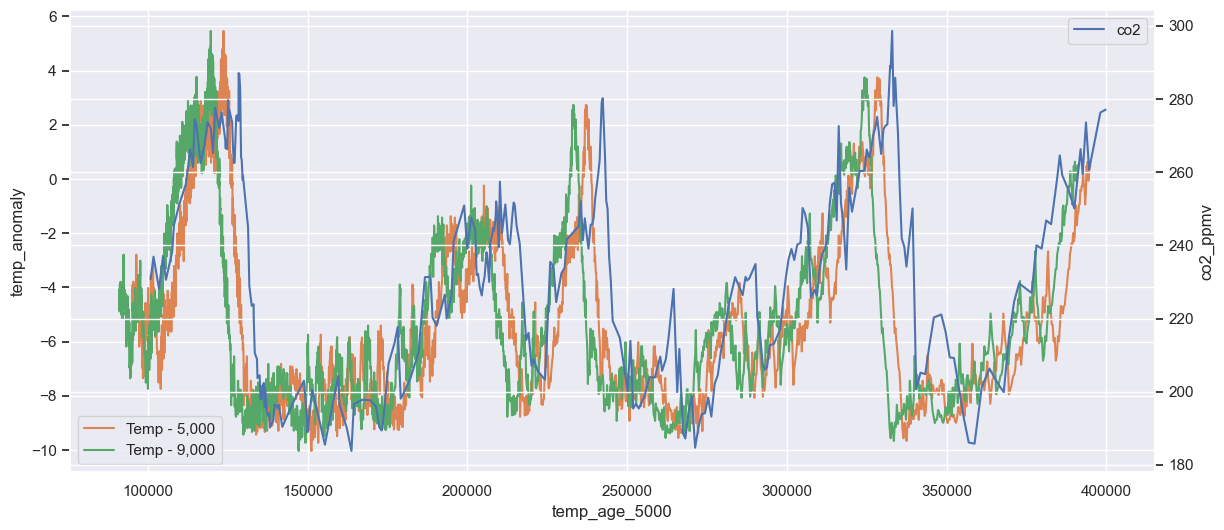

In [69]:
# For temp decrease
df_10_40k_temp['temp_age_5000'] = df_10_40k_temp['temp_age']
temp_column = df_10_40k_temp['temp_age_5000']
def add_offset(x):
    x -= 5000
    return x
new_temp_column = temp_column.apply(add_offset)
df_10_40k_temp['temp_age_5000']= new_temp_column

df_10_40k_temp['temp_age_9000'] = df_10_40k_temp['temp_age']
temp_column = df_10_40k_temp['temp_age_9000']
def add_offset(x):
    x -= 9000
    return x
new_temp_column = temp_column.apply(add_offset)
df_10_40k_temp['temp_age_9000']= new_temp_column

sns.lineplot(x = 'temp_age_5000', y = 'temp_anomaly', data=df_10_40k_temp, color='#dd8452', label = 'Temp - 5,000').legend(loc=4)
sns.lineplot(x = 'temp_age_9000', y = 'temp_anomaly', data=df_10_40k_temp, color='#55a868', label = 'Temp - 9,000').legend(loc=3)
ax2 = plt.twinx()
sns.lineplot(x = 'co2_age', y = 'co2_ppmv', data=df_10_40k_co2, label = 'co2')

this plot shows a longer lag when temp is reducing

Even though ice cores show that methane levels have varied significantly over the past millennia, methane concentrations began to rise sharply with the onset of industrialization.

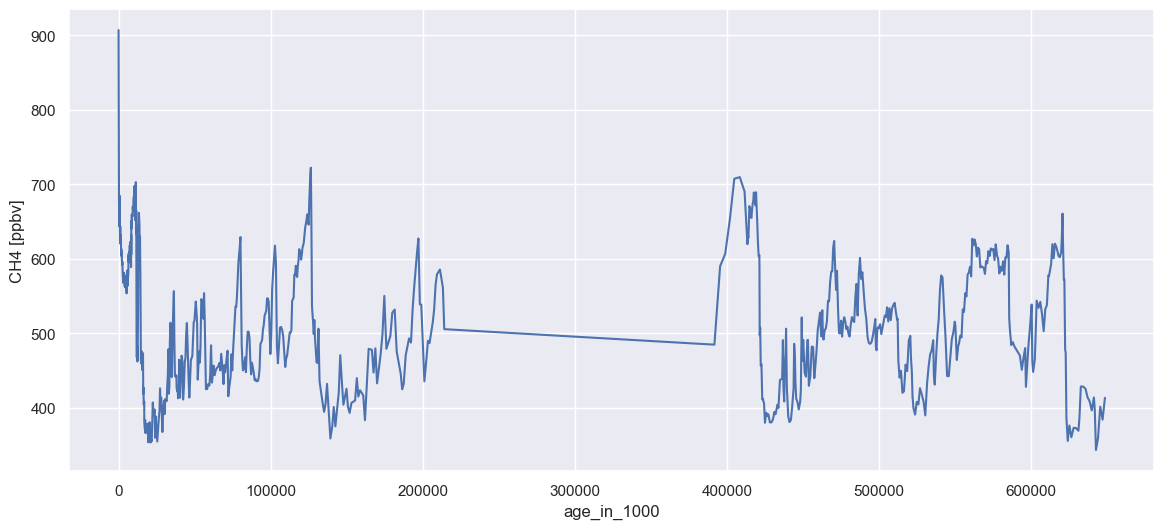

In [70]:
df_ch4_2=pd.read_csv('data/csv_files/EPICA Dome C methane.csv')
df_ch4_2['age_in_1000'] = df_ch4_2['Gas age']
temp_column = df_ch4_2['age_in_1000']
def add_offset(x):
    x *= 1000
    return x
new_temp_column = temp_column.apply(add_offset)
df_ch4_2['age_in_1000'] = new_temp_column
sns.lineplot(x = 'age_in_1000', y = 'CH4 [ppbv]', data=df_ch4_2)
plt.show()

In [71]:
# add a row to make the timelines match
new_row = [820, 400, 798512]
df_ch4_2.loc[len(df_ch4_2)] = new_row

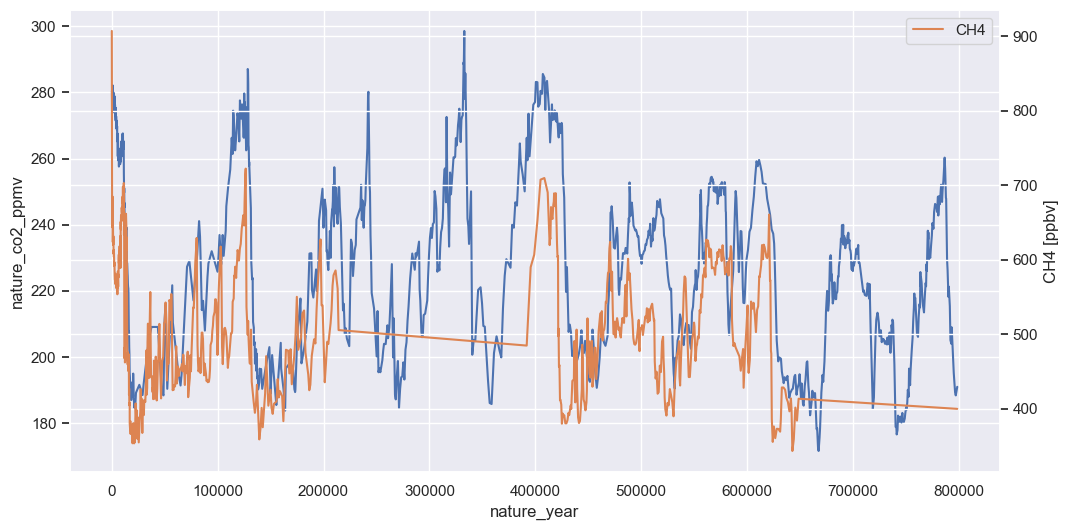

In [72]:
# co2 vs. ch4
sns.set(rc = {'figure.figsize':(12, 6)})
fig, (ax) = plt.subplots(nrows=1, sharex=False)

sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv', data=df)
ax2 = plt.twinx()
sns.lineplot(x = 'age_in_1000', y = 'CH4 [ppbv]', data=df_ch4_2, label = 'CH4',color='#dd8452')
plt.show()

#### Irish Data
***

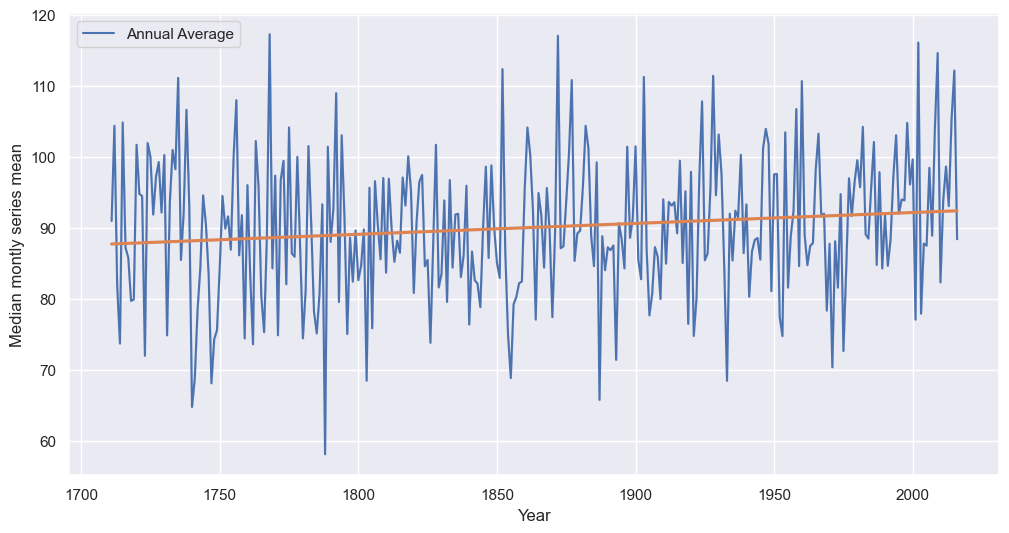

In [73]:
df_ie_rain=pd.read_csv('data/csv_files/1711_rainfall.csv')

means = df_ie_rain.groupby(['Year'])['Median montly series'].mean()
df_ie_rain = df_ie_rain.merge(right=means, left_on=['Year'], right_index=True, suffixes=('', ' mean'))

sns.set(rc = {'figure.figsize':(12, 6)})
fig, (ax) = plt.subplots()

sns.lineplot(x = 'Year', y = 'Median montly series mean', data=df_ie_rain, label = 'Annual Average')
sns.regplot(x = 'Year', y = 'Median montly series mean', scatter=False, ci=None, data=df_ie_rain)

plt.show()


https://www.met.ie/climate/what-we-measure/temperature

<Axes: xlabel='year', ylabel='annual_temp'>

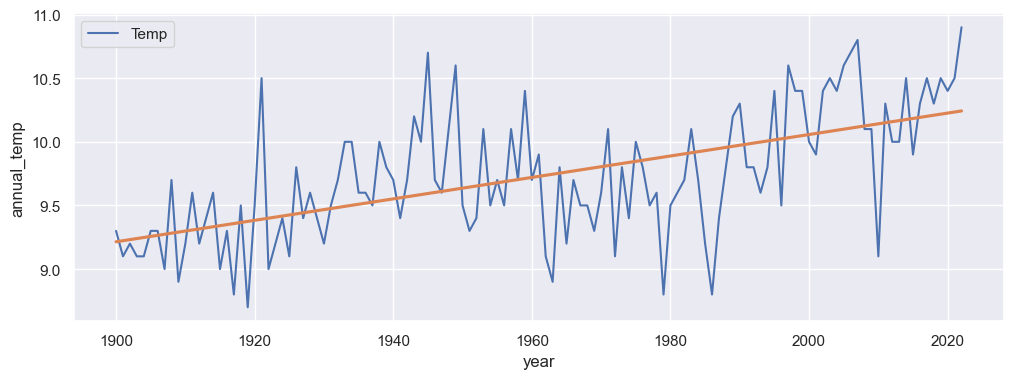

In [74]:
df_ie_temp=pd.read_csv('data/csv_files/long_term_temp_ie.csv')

sns.set(rc = {'figure.figsize':(12, 4)})
fig, ax = plt.subplots()
sns.lineplot(x = 'year', y = 'annual_temp', data=df_ie_temp, label = 'Temp')
sns.regplot(x = 'year', y = 'annual_temp', scatter=False, ci=None, data=df_ie_temp)

shows circa 1&deg; warming in 120 years

0.4584437441118029


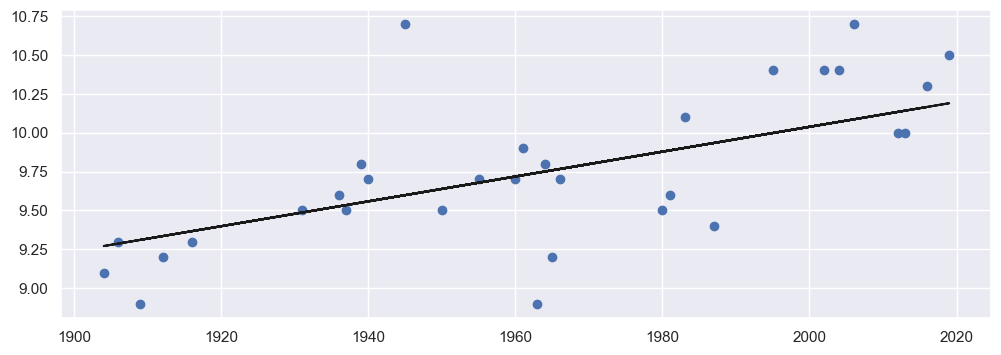

In [75]:
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = np.array(df_ie_temp['year']).reshape(-1, 1)
y = np.array(df_ie_temp['annual_temp']).reshape(-1, 1)
# Dropping any rows with Nan values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
 
# Splitting the data into training and testing data
regr = LinearRegression()
 
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

y_pred = regr.predict(X_test)
plt.scatter(X_test, y_test, color ='b')
plt.plot(X_test, y_pred, color ='k')

plt.show()
# Data scatter of predicted values


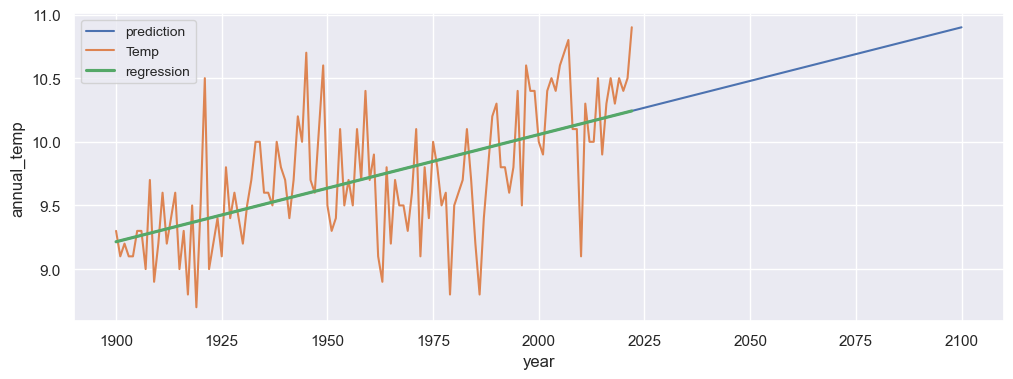

In [76]:
regr.fit(X, y)
X_200 = np.linspace(1900, 2100, 201) # 201 values between 1900 and 2100
X_200 = np.array(X_200).reshape(-1, 1)
y_pred = regr.predict(X_200)

df_pred = pd.DataFrame({'X_200': X_200[:, 0], 'y_pred': y_pred[:,0]})
 
sns.set(rc = {'figure.figsize':(12, 4)})
fig, ax = plt.subplots()

sns.lineplot(x = 'X_200', y = 'y_pred', data=df_pred, label = 'prediction')
sns.lineplot(x = 'year', y = 'annual_temp', data=df_ie_temp, label = 'Temp')
sns.regplot(x = 'year', y = 'annual_temp', scatter=False, ci=None, data=df_ie_temp, label = 'regression')
plt.legend(fontsize=10)
plt.show()

#### Instrument data
***
https://gml.noaa.gov/ccgg/trends/gl_data.html

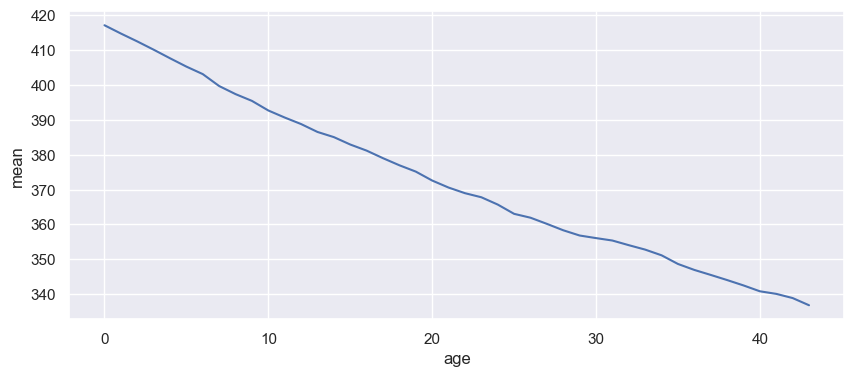

In [77]:
df_air_co2=pd.read_csv('data/csv_files/co2_gl_air_sample.csv')
df_air_co2['age'] = df_air_co2['year']
temp_column = df_air_co2['age']
def cal_age(x):
    x = 2022 - x
    return x
new_temp_column = temp_column.apply(cal_age)
df_air_co2['age'] = new_temp_column

sns.set(rc = {'figure.figsize':(10, 4)})
sns.lineplot(x = 'age', y = 'mean', data=df_air_co2)
plt.show()

#### grafting data

In [78]:
df_graft = df3
df_graft = df_graft.drop(labels=range(0, 6), axis=0)
df_graft = pd.DataFrame().assign(age =df_graft['Composite CO2 record (0-800 kyr BP)'], co2_ppmv = df_graft['Unnamed: 1'])

In [79]:
df_graft_2 = df_air_co2
df_graft_2 = df_graft_2.drop(['year', 'unc'], axis = 1)
df_graft_2 = df_graft_2[['age', 'mean']]
df_graft_2 = pd.DataFrame().assign(age =df_graft_2['age'], co2_ppmv = df_graft_2['mean'])

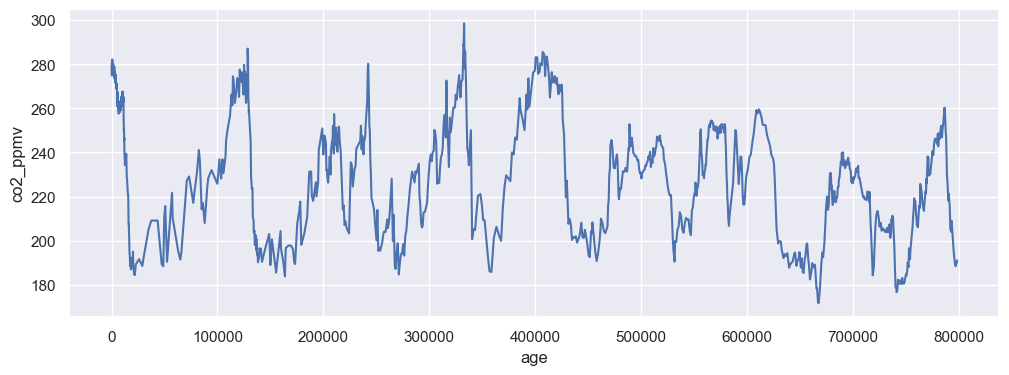

In [80]:
df_graft_co2 = pd.concat([df_graft, df_graft_2])
sns.set(rc = {'figure.figsize':(12, 4)})
sns.lineplot(x = 'age', y = 'co2_ppmv', data=df_graft)
plt.show()

In [81]:
#export as CSV
df_graft_co2.to_csv('data/csv_files/grafted_CO2_data.csv')

In [82]:
# export as json
df_graft_co2.to_json('data/csv_files/grafted_CO2_data.json', orient='records', lines=True)

In [83]:
dftemp=pd.read_csv('data/csv_files/grafted_CO2_data.csv')

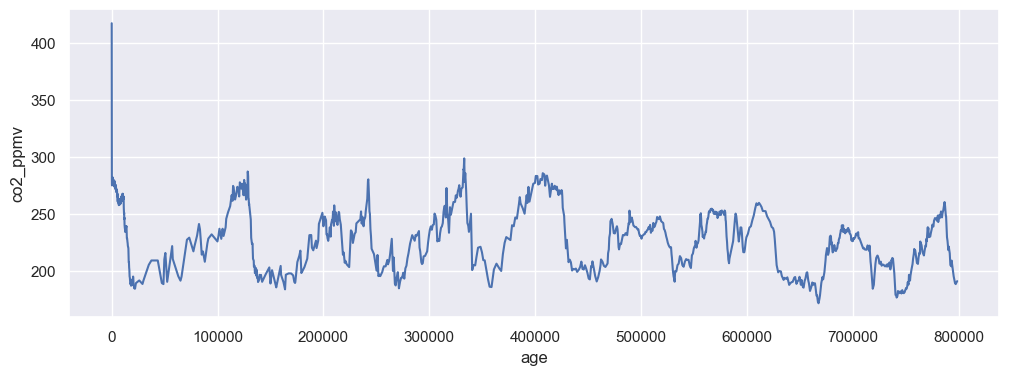

In [84]:
sns.lineplot(x = 'age', y = 'co2_ppmv', data=dftemp)
plt.show()

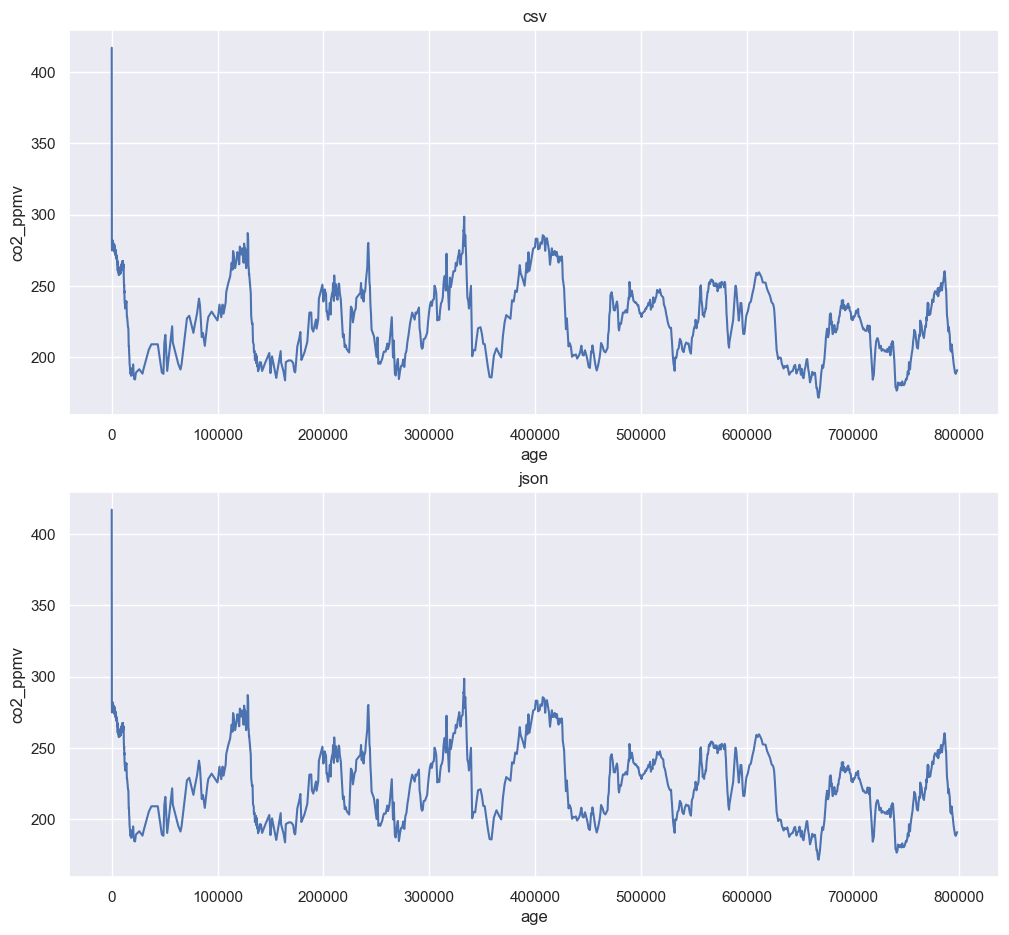

In [85]:
# test files
df_csv=pd.read_csv('data/csv_files/grafted_CO2_data.csv')
df_json=pd.read_json('data/csv_files/grafted_CO2_data.json', lines=True)

sns.set(rc = {'figure.figsize':(12, 11)})
fig, (ax1, ax2) = plt.subplots(nrows=2)
sns.lineplot(x = 'age', y = 'co2_ppmv', data=df_csv, ax = ax1).set(title='csv')
sns.lineplot(x = 'age', y = 'co2_ppmv', data=df_json, ax = ax2).set(title='json')
plt.show()

In [86]:
#https://data.marine.copernicus.eu/product/ARCTIC_OMI_SI_extent_obs/files?subdataset=arctic_omi_si_extent_obs_202311
# https://stackoverflow.com/questions/14035148/import-netcdf-file-to-pandas-dataframe
# Reading netCDF file
#ds = xr.open_dataset('data/arctic_omi_si_extent_19930115_P20220328.nc')
#df_si = ds.to_dataframe()
#export as CSV
#df_si.to_csv('data/csv_files/sea_ice.csv')


In [87]:
df_si = pd.read_csv('data/csv_files/sea_ice.csv')

In [88]:
# Using pandas.to_datetime() to convert pandas column to DateTime
df_si['time series'] = pd.to_datetime(df_si['time'], format = '%d/%m/%Y')
df_si['date_delta'] = (df_si['time series'] - df_si['time series'].min())  / np.timedelta64(1,'D')

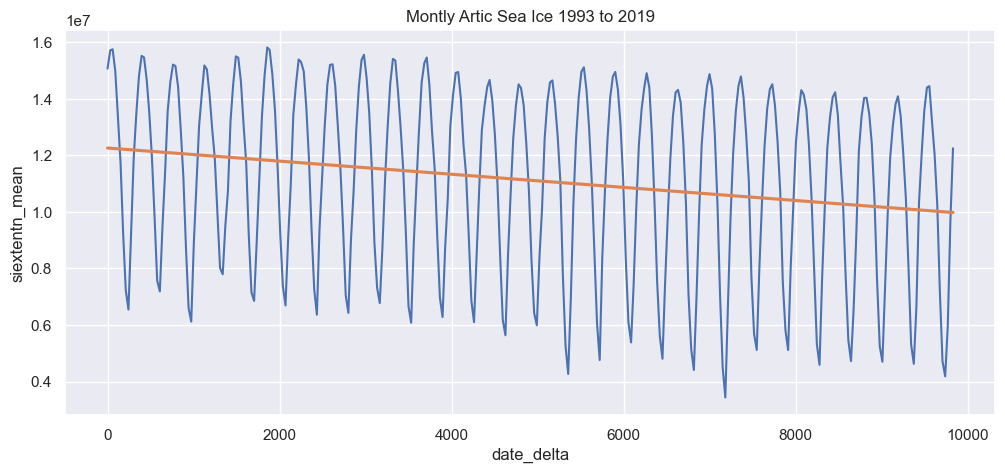

In [89]:
sns.set(rc = {'figure.figsize':(12, 5)})
fig, (ax) = plt.subplots(sharex=False)

sns.lineplot(x = 'date_delta', y = 'siextentn_mean', data=df_si).set(title='Montly Artic Sea Ice 1993 to 2019')
sns.regplot(x = 'date_delta', y = 'siextentn_mean', ci=None, scatter=False, dropna=False, data=df_si)
plt.show()

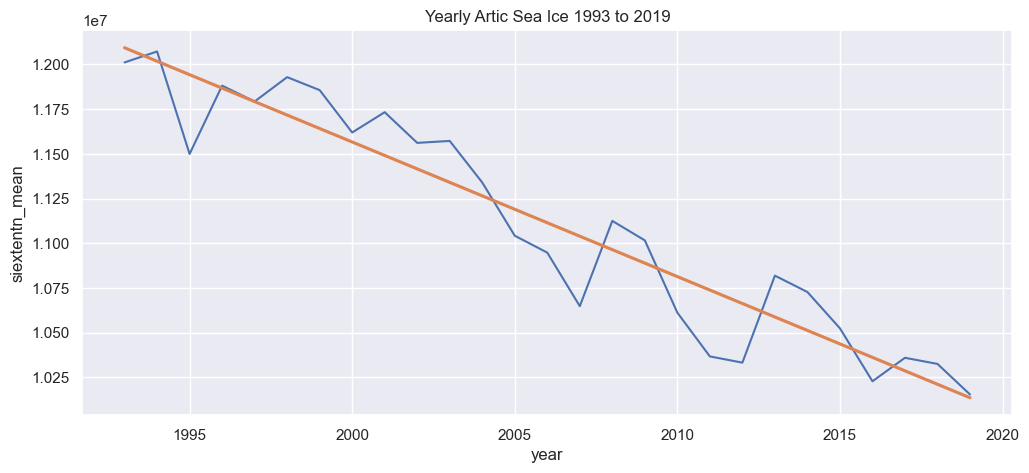

In [90]:
y = pd.to_datetime(df_si['time'], format = '%d/%m/%Y').dt.year.rename('year')
df_yearly_si = df_si.groupby(y)['siextentn_mean'].mean().reset_index()
sns.lineplot(x = 'year', y = 'siextentn_mean', data=df_yearly_si).set(title='Yearly Artic Sea Ice 1993 to 2019')
sns.regplot(x = 'year', y = 'siextentn_mean', scatter=False, ci=None, data=df_yearly_si)
plt.show()

## References
***
[1]	E.-G. Beck, “50 YEARS OF CONTINUOUS MEASUREMENT OF CO2 ON MAUNA LOA,” vol. 19, no. 7, 2008.

[2] Le Treut, H., R. Somerville, U. Cubasch, Y. Ding, C. Mauritzen, A. Mokssit, T. Peterson and M. Prather, "Historical Overview of Climate Change. "In: Climate Change 2007: The Physical Science Basis. Contribution of Working Group I to the Fourth Assessment Report of the Intergovernmental Panel on Climate Change [Solomon, S., D. Qin, M. Manning, Z. Chen, M. Marquis, K.B. Averyt, M. Tignor and H.L. Miller (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA , 2007


